# Speed Dating Experiment

In this project, we use KNN and Decision Tree to predict whether one person is going to date the other again or not.
  
Besides using these algorithms from scikit-learn, we also implement our own versions to compare efficient.  
  
The data are from kaggle [Speed Dating Experiment](https://www.kaggle.com/annavictoria/speed-dating-experiment).


# Table of Content
- [Setup](#setup)
- [Initial Data Processing](#initial)
- [Algorithm Implementation](#algorithm)
    - [KNN](#knn)
        - [Self Implement](#selfknn)
        - [Scikit Learn](#skknn)
    - [Decision Tree](#dt)
        - [Self Implement](#selfdt)
        - [Scikit Leran](#skdt)
- [Choosing Predcited Target](#target)
- [Visualize Methods](#visualizemetod)
- [Training Methods](#trainmethod)
    - [Baseline](#baseline)
    - [Drop Columns or Rows with Too Many Null](#nan)
    - [Hobby Similarity](#hob-sim)
    - [Vectorize Category](#vec-cate)
    - [Group Columns](#group-cols)
    - [Drop One Feature Each Time](#dropone)
- [Feature Selection](#feature-selction)

- [Conclusion](#conclusion)

# Contributors
- [Hao-Tzu Huang](https://github.com/nacat)
- [Wei Lee](https://github.com/Lee-W)

---

# <a name='setup'></a> Setup

In [1]:
import math
import json
import random
import time
from copy import deepcopy
from collections import Counter, Iterable
from functools import partial
from io import StringIO
from operator import itemgetter, attrgetter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

import pydot_ng as pydot
from IPython.display import Image, display

# <a name='initial'></a>Initial Data Processing

## Load Data

In [2]:
df = pd.read_csv('speed-dating-experiment/Speed Dating Data.csv', encoding="ISO-8859-1")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


- Number of rows (participants): 8378
- Number of columns (features): 195

In [4]:
# Unparseable columns

unparseable_cols = df.select_dtypes(include=['object']).columns
unparseable_cols

Index(['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income',
       'career'],
      dtype='object')

## Data Cleaning

The unparseable columns are handled as following

### `income, zipcode, tuition, mn_sat`
These columns contain commas and can be parsed to numbers after cleaning

In [5]:
# Clean Comma
COLUMNS_WITH_COMMA = ['income', 'zipcode', 'tuition', 'mn_sat']

for col in COLUMNS_WITH_COMMA:
    df[col] = df[col].replace(',', '', regex=True).astype(float)

### `career, field`
They have already been encoded in other columns (i.e. career_c, field_cd)  
Thus, we simply drop them.

In [6]:
ENCODED_STRING_COLUMNS = ['career', 'field']
df.drop(ENCODED_STRING_COLUMNS, axis=1, inplace=True)

## `undergra, from`
These two columns are pure strings.  
There are too many different contents in these columns.  
Thus, encoding them like `career` and `field` is unreasonable.  
  
We use `same_from` and `same_undergra` instead.  
The two values indicate that if the values of `undergra` and `from` are the same between the participant and his or her partner.  
If so, the value would be 1. Otherwise, it would be 0.

Then, `undergra` and `from` are dropped.

In [7]:
# Joined df based on partner
joined_df = df.merge(
    df,
    how='left',
    left_on=['iid', 'id', 'pid', 'partner'],
    right_on=['pid', 'partner', 'iid', 'id']
)

In [8]:
OTHER_STRING_COLUMNS = ['undergra', 'from']

df['same_from'] = joined_df['from_x'] == joined_df['from_y']
df['same_undergra'] = joined_df['undergra_x'] == joined_df['undergra_y']
df.drop(OTHER_STRING_COLUMNS, axis=1, inplace=True)

---

# <a name='algorithm'></a> Algorithm Implementation

## <a name='knn'></a> KNN

### <a name='selfknn'></a> Self Implement

In [9]:
def to_tuple(v):
    if isinstance(v, Iterable): 
        v = (v, )
    return v

In [10]:
def eucldn_similarity(v1, v2):
    """
    Euclidean Distance。越相似，距離越近，相似度數值會越小。
    :param v1:
    :param v2:
    :return: 1/distance(v1,v2) 取距離的倒數，越大越像
    """
    distance = np.sqrt(np.sum(np.power(v1-v2, 2)))
    return 1 / distance

In [11]:
def cos_similarity(v1, v2):
    """
    Cosine（兩向量的餘弦）。越相似，夾角越小，相似度數值會越高。
    :param v1:
    :param v2:
    :return: cos(v1,v2)介於1到-1之間 越大越像
    """          
    son = np.sum(np.multiply(v1,v2))
    mom = np.sqrt(np.sum(np.power(v1, 2) * np.sum(np.power(v2, 2))))
    cosin = son / mom
    return cosin

In [12]:
def knn_prediction(nb_list):
    cnt = Counter(target for (sim, target) in nb_list)
    label = cnt.most_common(1)[0][0]
    return label

In [13]:
def knn_classify(test_X, train_X, train_y, k=5):
    nb = []
    for feature, label in zip(train_X, train_y):
        nb.append((cos_similarity(test_X,feature),to_tuple(label)))

    nb.sort(reverse=True)
    label = knn_prediction(nb[:k])
    return label

In [14]:
def knn(train_X, test_X, train_y, test_y, n_neighbors=5):
    count = 0
    for feature, label in zip(test_X, test_y):
        pred_y = knn_classify(feature, train_X, train_y, n_neighbors)
        if pred_y == to_tuple(label):
            count += 1
    accuracy = count / len(test_X)
    return accuracy

## <a name='skknn'></a> Scikit Learn

In [15]:
def knn_with_sklearn(train_X, test_X, train_y, test_y,
                     **kwargs):
    clf = KNeighborsClassifier(**kwargs)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    return accuracy_score(pred, test_y)

# <a name='dt'></a> Decision Tree

## <a name='selfdt'></a> Self Implement

In [16]:
def gini_index(lcnt, rcnt):
    gini = 0.0
    tcnt = lcnt + rcnt
    tl = sum(lcnt.values())
    tr = sum(rcnt.values())
    tt = tl + tr
    l = 0.0
    r = 0.0
    for class_label in set(tcnt):
        if tl is not 0:
            l += pow(lcnt[class_label]/tl,2)
        if tr is not 0:    
            r += pow(rcnt[class_label]/tr,2)
    if tt is not 0:
        gini = (tl/tt)*(1-l)+(tr/tt)*(1-r)
    return gini

In [17]:
def try_split(train_X, train_y, index, value):
    gini = 1.0
    left_X, right_X = list(), list()
    left_y, right_y = list(), list()
    lcnt, rcnt, tcnt = Counter(), Counter(), Counter
    for row_X, row_y in zip(train_X, train_y):
        if row_X[index] < value:
            left_X.append(row_X)
            left_y.append(row_y)
            lcnt[to_tuple(row_y)] += 1
        else:
            right_X.append(row_X)
            right_y.append(row_y)
            rcnt[to_tuple(row_y)] += 1
    if not left_X:
        l = 0
    else:
        l = lcnt.most_common(1)[0][0]
    if not right_X:
        r = 0
    else:
        r = rcnt.most_common(1)[0][0]
    gini = gini_index(lcnt, rcnt)
    return gini, left_X, right_X, left_y, right_y, l, r

In [18]:
def determine_split(train_X, train_y):
    calculated = set()
    b_feature, b_value, b_gini, b_group = 999, 999, 999, None
    for index in range(len(train_X[0])):
        for tp in train_X:
            if tp[index] not in calculated:
                calculated.add(tp[index])
                gini, left_group, right_group, left_label, right_label, l, r= try_split(train_X, train_y, index, tp[index])
                groups = left_group, right_group
                labels = left_label, right_label
                counter = l, r
                if gini < b_gini:
                    b_index, b_value, b_gini, b_group, b_label, b_cnt= index, tp[index], gini, groups, labels, counter
                if gini == 0.0:
                    break
    return {'index':b_index, 'value':b_value, 'gini':b_gini, 'groups':b_group, 'labels':b_label, 'count':b_cnt}

In [19]:
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    l_label, r_label = node['labels']
    l_cnt, r_cnt = node['count']

    if not left or not right:
        if isinstance(l_cnt, tuple):
            node['left'] = node['right'] = l_cnt
        elif isinstance(r_cnt, tuple):
            node['left'] = node['right'] = r_cnt
        else:
            node['left'] = node['right'] = None
        return
    if depth >= max_depth:
        node['left'], node['right'] = l_cnt, r_cnt
        return
    if len(left) <= min_size:
        node['left'] = l_cnt
    else:
        node['left'] = determine_split(left, l_label)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = r_cnt
    else:
        node['right'] = determine_split(right, r_label)
        split(node['right'], max_depth, min_size, depth+1)

In [20]:
def build_tree(train_X, train_y, max_depth, min_size):
    root = determine_split(train_X, train_y)
    split(root, max_depth, min_size, 1)
    return root

In [21]:
def dt_predict(tp, node):
    if tp[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return dt_predict(tp, node['left'])
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return dt_predict(tp, node['right'])
        else:
            return node['right']

In [22]:
def dt_accuracy(test_X, test_y, tree):
    accuracy = 0
    count = 0
    for tp, label in zip(test_X, test_y):
        pred = dt_predict(tp, tree)
        if pred == to_tuple(label):
            count += 1
    accuracy = count/len(test_y)
    return accuracy

In [23]:
def dt(train_X, test_X, train_y, test_y, max_depth=5, min_samples_leaf=5):
    accuracy = 0
    tree = build_tree(train_X, train_y, max_depth, min_samples_leaf)
    accuracy = dt_accuracy(test_X, test_y, tree)
    return accuracy

## <a name='skdt'></a> Scikit Learn

In [24]:
def dt_with_sklearn(train_X, test_X, train_y, test_y,
                    feature_names=None, visualize=False, **kwargs):
    if 'random_state' not in kwargs:
        kwargs['random_state'] = 0
        
    clf = tree.DecisionTreeClassifier(**kwargs)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    if visualize:
        visualize_dt(clf, feature_names)
    return accuracy_score(pred, test_y)

In [25]:
# Visualize Decision Tree

def visualize_dt(clf, feature_names=None):
    dot_data = StringIO()
    tree.export_graphviz(clf, out_file=dot_data,
                         class_names=True, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

---

# <a name='target'></a> Choosing Predicted Target

Initially, we chose the column `match` as the predicted target.  

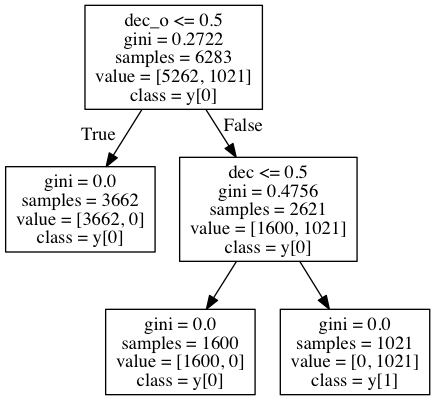

1.0

In [26]:
copy_df = deepcopy(df)
copy_df.fillna(0, inplace=True)

copy_df_X = copy_df.drop('match', axis=1)
copy_df_y = copy_df['match']

X, y = np.array(copy_df_X), np.array(copy_df_y)
dt_with_sklearn(*train_test_split(X, y),
                visualize=True, feature_names=copy_df_X.columns)

However, the accuracy of using Decision Tree with all the features to predict `match` is 100% which is unreasonably high.  
After visualizing it (the figure above), we found that `match` could be directly decided by `dec` and `dec_o` as the following rule.

|dec|dec_o|match|
|---|---|---|
|1|1|1|
|1|0|0|
|0|1|0|
|0|0|0|

In other words, only when both `dec` and `dec_o` are true, will `match` be true.  

Thus, `dec` and `dec_o` would be redundant when `match` is used as predict target.

However, using one single column to predict `match` could achieve an accuracy rate at around 82% which is still unreasonable.

In [27]:
copy_df['match'].value_counts()

0    6998
1    1380
Name: match, dtype: int64

According to the ratio above, if our model always guesses 0, we can get accuracy at 83.528%.  

We concluded that KNN and Decision Tree might not do well on skew data.  

In [28]:
copy_df['dec'].value_counts()

0    4860
1    3518
Name: dec, dtype: int64

In [29]:
copy_df['dec_o'].value_counts()

0    4863
1    3515
Name: dec_o, dtype: int64

On the other hand, using `dec` and `dec_o` would not encounter such problem.  
  
Since the data are mostly about the participant, **we decided to use `dec` as predict target.**  
  
Although using `match` as a feature could get an accuracy around 86% without any tuning, we thought using `match` to predict `dec` is meaningless.  
Thus, we dropped `match`.

In [30]:
df.drop('match', axis=1, inplace=True)

---
# <a name='visualizemethod'></a> Visualize Methods

In [31]:
def visualize_feature_distribute(df, col, default_na=0):
    visual_df = df.fillna(default_na)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    f.suptitle('{col_name} distribution'.format(col_name=col))
    ax1.hist(visual_df[col], color='blue')
    ax1.set_xlabel('all')
    ax2.hist(visual_df[visual_df.dec == 1][col], color='red')
    ax2.set_xlabel('dec = 1')
    ax3.hist(visual_df[visual_df.dec == 0][col], color='green')
    ax3.set_xlabel('dec = 0')
    plt.show(f)

e.g.

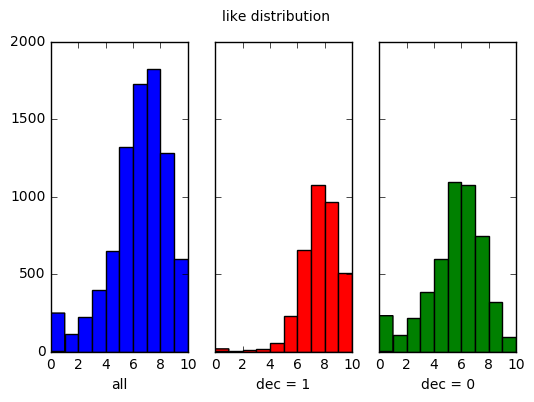

In [32]:
visualize_feature_distribute(df, 'like')


---

# <a name='trainmethod'></a> Training Methods

### Split Data

We used 20% of the data as testing data and set random_state to a fixed number so that the split data will always be the same.

In [33]:
def split_df(df, predict_targt='dec',
             default_na=0, test_size=0.2, random_state=0):    
    df = df.fillna(default_na)
    
    df_X = df.drop(predict_targt, axis=1)
    df_y = df[predict_targt]
    
    X, y = np.array(df_X), np.array(df_y)
    return train_test_split(X, y,
                            test_size=test_size, random_state=random_state)    

### Training with All Methods

In [34]:
def train_with_all_methods(df, verbose=True, run_self=False, **conf):
    split_args = conf.get('split_args', dict())
    knn_args = conf.get('knn_args', dict())
    dt_args = conf.get('dt_args', dict())
    
    data = split_df(df, **split_args)
    t1 = time.clock()
    sklearn_knn_acc = knn_with_sklearn(*data, **knn_args)
    t2 = time.clock()
    sklearn_dt_acc = dt_with_sklearn(*data, **dt_args)
    t3 = time.clock()
    if run_self:
        self_knn_acc = knn(*data, *knn_args)
        t4 = time.clock()
        self_dt_acc = dt(*data, *dt_args)
        t5 = time.clock()
    
    if verbose:
        print('Sklearn KNN Accurary: {}, Spends: {}s'.format(sklearn_knn_acc, t2-t1))
        print('Sklearn DT Accurary: {}, Spends: {}s'.format(sklearn_dt_acc, t3-t2))
        if run_self:
            print('KNN Accurary: {}, Spends: {}m {}s'.format(
                    self_knn_acc, int((t4-t3)/60), (t4-t3)%60)
            )
            print('DT Accurary: {}, Spends: {}s'.format(self_dt_acc, t5-t4))
    return np.array([sklearn_knn_acc, sklearn_dt_acc])

### Training with Different Split

In case that the model might overfit the training data, we split the data with more than one random_state to get the average accuracy.

In [35]:
def train_with_diff_split(df, conf=None, sample_num=3, verbose=True, run_self=False,
                          random_states=None, rand_min=0, rand_max=100):
    if not random_states:
        random.seed(0)
        random_states = [random.randint(rand_min, rand_max)
                         for _ in range(sample_num)]
        
    if not conf:
        conf = dict()
    conf.setdefault('split_args', {'random_state': 0})
    
    all_accs = list()
    for i, s in enumerate(random_states, 1):
        if verbose:
            print('\n-----iter {}, random_state {}---'.format(i, s))
        conf['split_args']['random_state'] = s
        all_accs.append(train_with_all_methods(df, conf=conf, run_self=run_self))
    return np.average(all_accs, axis=0)

### Compare Accuracy

In [36]:
def compare_acc(acc1, acc2):
    return acc1 - acc2

---

# <a name='feature-selction'></a> Feature Selection

- [Baseline](#baseline)
- [Drop Columns or Rows with Too Many Null](#nan)
- [Hobby Similarity](#hob-sim)
- [Vectorize Category](#vec-cate)
- [Group Columns](#group-cols)
- [Drop One Feature Each Time](#dropone)


### Preprocessing
We group related columns as groups of features.  
They are defined in "feature_group.json"

In [37]:
with open('feature_group.json', 'r') as input_file:
    feature_groups = json.load(input_file)

---
## <a name='baseline'></a> Baseline

We use all the columns to predict `dec`.  
This is regarded as our baseline result.

In [38]:
baseline_df = deepcopy(df)

### Training

In [39]:
train_with_all_methods(baseline_df, run_self=True)

Sklearn KNN Accurary: 0.6873508353221957, Spends: 0.38687700000000014s
Sklearn DT Accurary: 0.7750596658711217, Spends: 0.6172120000000003s
KNN Accurary: 0.6831742243436754, Spends: 21m 31.352157999999918s
DT Accurary: 0.6736276849642004, Spends: 156.75838s


array([ 0.68735084,  0.77505967])

In [40]:
baseline_acc = train_with_diff_split(baseline_df)
baseline_acc


-----iter 1, random_state 49---
Sklearn KNN Accurary: 0.6873508353221957, Spends: 0.4123019999999542s
Sklearn DT Accurary: 0.7750596658711217, Spends: 0.6498830000000453s

-----iter 2, random_state 97---
Sklearn KNN Accurary: 0.6873508353221957, Spends: 0.40747399999986555s
Sklearn DT Accurary: 0.7750596658711217, Spends: 0.6300029999999879s

-----iter 3, random_state 53---
Sklearn KNN Accurary: 0.6873508353221957, Spends: 0.4743679999999131s
Sklearn DT Accurary: 0.7750596658711217, Spends: 0.7274250000000393s


array([ 0.68735084,  0.77505967])

### Method to Compare Accuarcy with Baseline

In [41]:
compare_acc_with_baseline = partial(compare_acc, acc2=baseline_acc)

---

## <a name='nan'></a> Drop Columns or Rows with Too Many Null
Since there are too many empty values in this data, we'd like to find out whether dropping some columns or rows with lots of null values can enhance accuracy.

In [42]:
df_drop_nan = deepcopy(df)

### Analysis

In [43]:
# Number of null value of each columns

cols_to_null_nums = df_drop_nan.isnull().sum(axis=0).sort_values(ascending=False)
cols_to_null_nums[:10]

num_in_3    7710
numdat_3    6882
expnum      6578
sinc7_2     6423
amb7_2      6423
shar7_2     6404
attr7_2     6394
fun7_2      6394
intel7_2    6394
attr5_3     6362
dtype: int64

In [44]:
# Number of null value of each row

rows_to_null_nums = df_drop_nan.isnull().sum(axis=1).sort_values(ascending=False)
rows_to_null_nums[:10]

839    168
842    168
843    168
845    168
847    168
838    167
324    155
841    151
840    150
844    150
dtype: int64

We found that some columns and rows are mostly empty.  

### Data Processing

In [45]:
def drop_nan_with_thresh(df, row_thresh=0, col_thresh=0):
    if 0 < row_thresh < 1:
        row_thresh = len(df.columns) * row_thresh
    if 0 < col_thresh < 1:
        col_thresh = len(df) * col_thresh
    
    df_drop_nan = df.dropna(axis=0, thresh=row_thresh)
    return df_drop_nan.dropna(axis=1, thresh=col_thresh)

In [46]:
df_drop_nan = drop_nan_with_thresh(df_drop_nan, col_thresh=1200)

### Training

In [47]:
drop_nan_acc = train_with_diff_split(df_drop_nan)
drop_nan_acc


-----iter 1, random_state 49---
Sklearn KNN Accurary: 0.6873508353221957, Spends: 0.37578700000017307s
Sklearn DT Accurary: 0.7810262529832935, Spends: 0.6726819999998952s

-----iter 2, random_state 97---
Sklearn KNN Accurary: 0.6873508353221957, Spends: 0.3914270000000215s
Sklearn DT Accurary: 0.7810262529832935, Spends: 0.5947380000000067s

-----iter 3, random_state 53---
Sklearn KNN Accurary: 0.6873508353221957, Spends: 0.46753400000011425s
Sklearn DT Accurary: 0.7810262529832935, Spends: 0.7120399999998881s


array([ 0.68735084,  0.78102625])

### Compare

In [48]:
compare_acc_with_baseline(drop_nan_acc)

array([ 0.        ,  0.00596659])

Dropping columns with less than 1200 non-null values could increase accuracy.  

---
## <a name='hob-sim'></a> Hobby Similarity
Instead of using hobby directly, we count the number of similar hobbies between the participant and his or her partner.  
If the difference of their scores on a certain hobby is less than the threshold, then we say they have similar preference on this hobby.

In [49]:
df_hs = deepcopy(df)

### Data Processing

In [50]:
def count_feature_similarity(joined_df, features,
                             sim_thres=1, na_default=-1):
    joined_df_no_na = joined_df.fillna(na_default)
    sims = list()
    for feature in features:
        temp_s = abs(joined_df_no_na[feature+'_x'] - joined_df_no_na[feature+'_y'])
        temp_s = (temp_s <= sim_thres).astype(int)
        sims.append(temp_s)
    return sum(sims)

In [51]:
df_hs['sim_hob_num'] = count_feature_similarity(
    joined_df, feature_groups['hobby'], sim_thres=3
)

In [52]:
df_hs.drop(feature_groups['hobby'], axis=1, inplace=True)

### Training

In [53]:
hs_acc = train_with_diff_split(df_hs)
hs_acc


-----iter 1, random_state 49---
Sklearn KNN Accurary: 0.6891408114558473, Spends: 0.4245100000000548s
Sklearn DT Accurary: 0.7690930787589498, Spends: 0.5398889999999028s

-----iter 2, random_state 97---
Sklearn KNN Accurary: 0.6891408114558473, Spends: 0.3620229999999083s
Sklearn DT Accurary: 0.7690930787589498, Spends: 0.5639289999999164s

-----iter 3, random_state 53---
Sklearn KNN Accurary: 0.6891408114558473, Spends: 0.3636189999999715s
Sklearn DT Accurary: 0.7690930787589498, Spends: 0.5490480000000844s


array([ 0.68914081,  0.76909308])

### Compare

In [54]:
compare_acc_with_baseline(hs_acc)

array([ 0.00178998, -0.00596659])

When the threshold is set to 3, KNN's accuracy increased by 0.2%.

---

## <a name='vec-cate'></a> Vectorize Category 

Doing arithmetic operations on category data is meaningless.  
Thus, we transformed these columns into vectors and dropped them.

e.g.
[1, 2, 3] -> [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

The columns included
- race, race_o
- go_out
- goal
- career_c

### Data Processing

In [55]:
df_vc = deepcopy(baseline_df)

In [56]:
def vectorize_column(df, col):
    v_df = pd.get_dummies(df[col], prefix=col)
    return df.drop(col, axis=1).join(v_df)

In [57]:
category_cols = ['career_c','race', 'race_o', 'go_out', 'goal']

for col in category_cols:
    df_vc = vectorize_column(df_vc, col)

### Training

In [58]:
vc_acc = train_with_diff_split(df_vc)
vc_acc


-----iter 1, random_state 49---
Sklearn KNN Accurary: 0.6867541766109785, Spends: 0.5009850000001279s
Sklearn DT Accurary: 0.7750596658711217, Spends: 0.7480599999998958s

-----iter 2, random_state 97---
Sklearn KNN Accurary: 0.6867541766109785, Spends: 0.49733000000014727s
Sklearn DT Accurary: 0.7750596658711217, Spends: 0.689391999999998s

-----iter 3, random_state 53---
Sklearn KNN Accurary: 0.6867541766109785, Spends: 0.4790539999999055s
Sklearn DT Accurary: 0.7750596658711217, Spends: 0.694302000000107s


array([ 0.68675418,  0.77505967])

### Compare

In [59]:
compare_acc_with_baseline(vc_acc)

array([-0.00059666,  0.        ])

This method has minnor improvement on KNN.

----

## <a name='group-cols'></a> Group Columns

As mentioned at the beginning of the section "Feature Selection", we grouped features.  
In this experiment, we tried to find out which group of features works well.

In [60]:
group_df = deepcopy(baseline_df)

### Using One Group to Predict

In [61]:
group_accs = list()
for group_name, features in feature_groups.items():
    temp_df = group_df[features].join(group_df['dec'])
    temp_acc = train_with_all_methods(temp_df, verbose=False)
    group_accs.append((group_name, temp_acc))

In [62]:
def sort_group_accs(accs):
    knn_accs = [
        (name, acc[0])
        for name, acc in sorted(accs, key=lambda x: x[1][0], reverse=True)
    ]
    
    dt_accs = [
        (name, acc[1]) for name ,acc in sorted(accs, key=lambda x: x[1][1], reverse=True)
    ]
    return knn_accs, dt_accs

In [63]:
def visulize_accs(accs, hline=0, title=''):
    x = range(len(accs))
    y, labels = list(), list()
    for name, acc in accs:
        y.append(acc)
        labels.append(name)
        
    plt.plot(x, y)
    plt.xticks(x, labels, rotation=45)
    plt.title(title)
    plt.axhline(color='red', y=hline)
    plt.show()

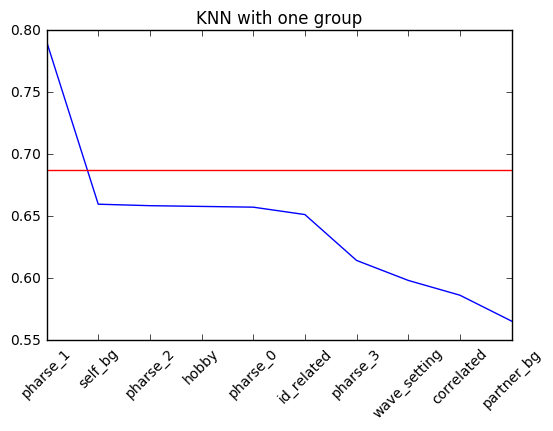

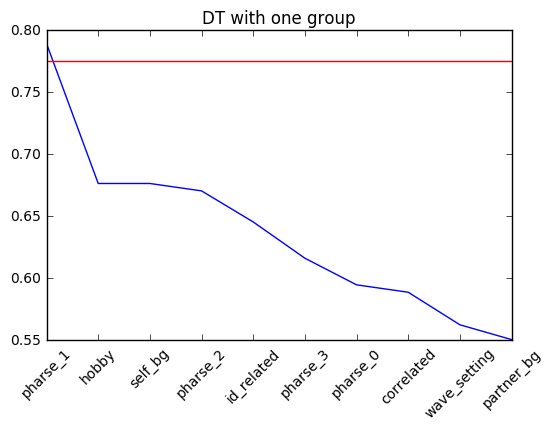

In [64]:
knn_accs, dt_accs = sort_group_accs(group_accs)
visulize_accs(knn_accs, baseline_acc[0], 'KNN with one group')
visulize_accs(dt_accs, baseline_acc[1], 'DT with one group')

According the result above, using only group `pharse_1` could significantly improve accuracy, especially for KNN.  
  
However, there are some groups containing insufficient features to predict.  
Thus, we combine other groups with `pharse_1` to see which combination has the best result.  

In [65]:
group_accs = list()
for group_name, features in feature_groups.items():
    if group_name == 'pharse_1':
        continue
        
    features = deepcopy(features)
    features.extend(feature_groups['pharse_1'])
    
    temp_df = group_df[features].join(group_df['dec'])
    temp_acc = train_with_all_methods(temp_df, verbose=False)
    group_accs.append((group_name, temp_acc))

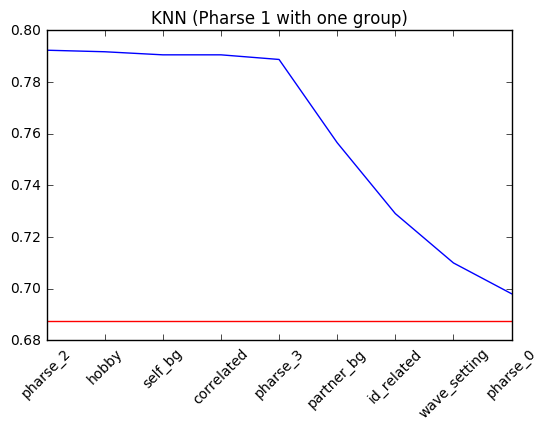

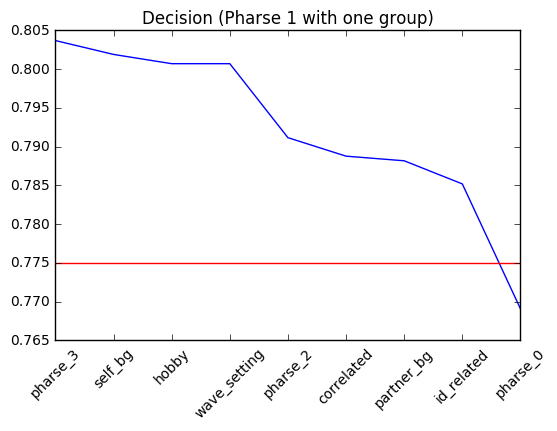

In [66]:
knn_accs, dt_accs = sort_group_accs(group_accs)
visulize_accs(knn_accs, baseline_acc[0], 'KNN (Pharse 1 with one group)')
visulize_accs(dt_accs, baseline_acc[1], 'Decision (Pharse 1 with one group)')

The result varies between two algorithms.  
However, the combination of `pharse_1` and `pharse_0` doesn't perform well in both cases.

### Drop One Group to Predict

Drop one group to see which group influences accuracy the most.

In [67]:
group_accs = list()
for name, features in feature_groups.items():
    temp_df = group_df.drop(features, axis=1)
    temp_acc = train_with_all_methods(temp_df, verbose=False)
    group_accs.append((name, temp_acc))

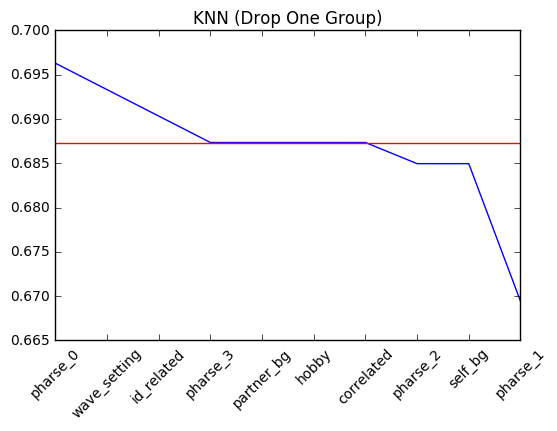

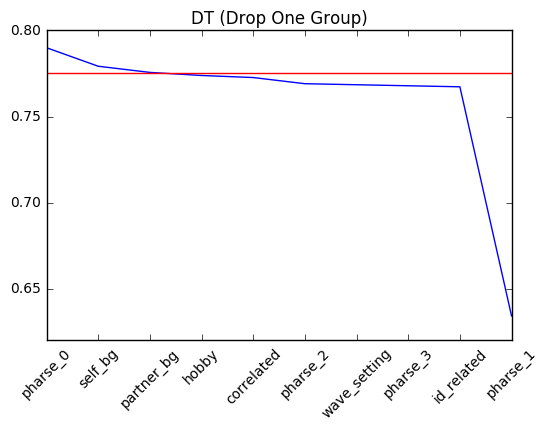

In [68]:
knn_accs, dt_acs = sort_group_accs(group_accs)
visulize_accs(knn_accs, baseline_acc[0], 'KNN (Drop One Group)')
visulize_accs(dt_acs, baseline_acc[1], 'DT (Drop One Group)')

We found that `pharse_1` is the most important group and that `pharse_0` can even harm accuracy.

### Find Which Features in group Pharse_1 Influences the Most

- Pharse_1 result

In [69]:
pharse_1_df = group_df[feature_groups['pharse_1']].join(group_df['dec'])
pharse_1_acc = train_with_diff_split(pharse_1_df)
pharse_1_acc


-----iter 1, random_state 49---
Sklearn KNN Accurary: 0.7911694510739857, Spends: 0.1616189999999733s
Sklearn DT Accurary: 0.7893794749403341, Spends: 0.12556199999994533s

-----iter 2, random_state 97---
Sklearn KNN Accurary: 0.7911694510739857, Spends: 0.203125s
Sklearn DT Accurary: 0.7893794749403341, Spends: 0.109958000000006s

-----iter 3, random_state 53---
Sklearn KNN Accurary: 0.7911694510739857, Spends: 0.1743509999998878s
Sklearn DT Accurary: 0.7893794749403341, Spends: 0.1190520000000106s


array([ 0.79116945,  0.78937947])

In [70]:
compare_acc_with_baseline(pharse_1_acc)

array([ 0.10381862,  0.01431981])

In [71]:
pharse_1_col_accs = list()
for col in pharse_1_df.columns:
    if col == 'dec':
        continue
    temp_df = pharse_1_df.drop(col, axis=1)
    temp_acc = train_with_all_methods(temp_df, verbose=False)
    pharse_1_col_accs.append((col, temp_acc))

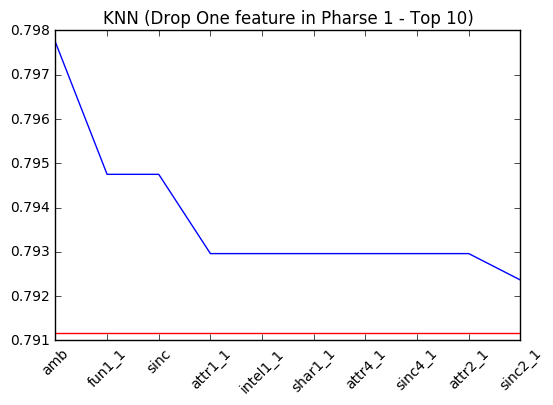

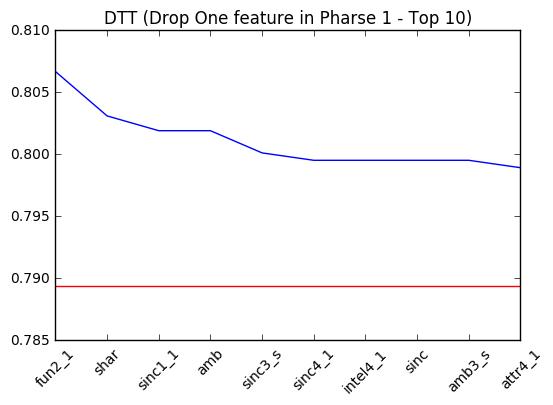

In [72]:
knn_accs, dt_accs = sort_group_accs(pharse_1_col_accs)
visulize_accs(knn_accs[:10], pharse_1_acc[0], 'KNN (Drop One feature in Pharse 1 - Top 10)')
visulize_accs(dt_accs[:10], pharse_1_acc[1], 'DTT (Drop One feature in Pharse 1 - Top 10)')

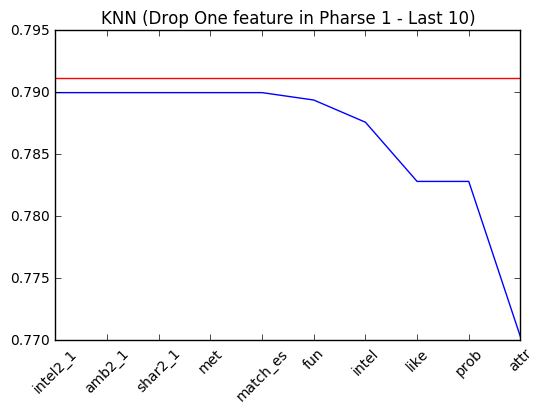

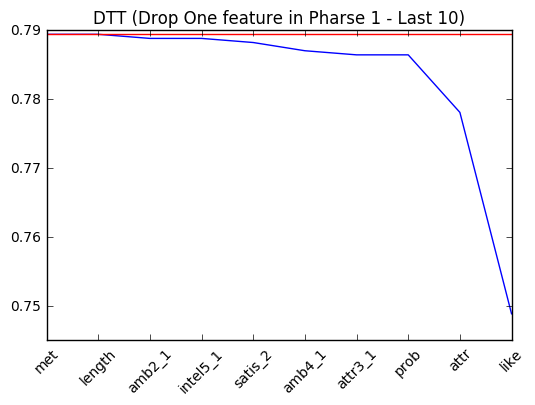

In [73]:
knn_accs, dt_accs = sort_group_accs(pharse_1_col_accs)
visulize_accs(knn_accs[-10:], pharse_1_acc[0], 'KNN (Drop One feature in Pharse 1 - Last 10)')
visulize_accs(dt_accs[-10:], pharse_1_acc[1], 'DTT (Drop One feature in Pharse 1 - Last 10)')

We found that `like`, `prob`, `met` and `attr` are the most important features.  

However, the important features to KNN and Decision Tree vary a lot.  
Thus, in the following sections, we'll use different feature sets to train the method.

---

## <a name='dropone'></a> Drop One Feature Each Time

In the last section, we conclude that using group "pharse_1" to preditct gets the highest accuracy.  
In this section, we're going to drop the feature performing the worst each time, recalculate the influence of all the remaining features and repeat this procedure until no improvement can be made.

In [74]:
def drop_cols_till_no_improvement(df, prev_acc, train_func):
    accs = list()
    for col in df.columns:
        if col == 'dec':
            continue
        temp_df = df.drop(col, axis=1)
        temp_acc = train_func(*split_df(temp_df))
        accs.append((col, temp_acc))
        
    max_col, new_acc = max(accs, key=lambda x: x[1])
    if new_acc >= prev_acc:
        return drop_cols_till_no_improvement(df.drop(max_col, axis=1), new_acc, train_func)
    else:
        return df.columns, prev_acc

In [75]:
current_knn_acc, current_dt_acc = pharse_1_acc

knn_df = deepcopy(pharse_1_df)
dt_df = deepcopy(pharse_1_df)

In [76]:
knn_columns, knn_best_acc = drop_cols_till_no_improvement(
    knn_df, current_knn_acc, knn_with_sklearn
)

In [77]:
dt_columns, dt_best_acc = drop_cols_till_no_improvement(
    dt_df, current_dt_acc, dt_with_sklearn
)

In [78]:
print(knn_columns)
print(knn_best_acc)

Index(['sinc1_1', 'intel1_1', 'shar1_1', 'attr4_1', 'amb4_1', 'shar4_1',
       'attr2_1', 'intel2_1', 'fun2_1', 'attr', 'intel', 'shar', 'like',
       'prob', 'met', 'match_es', 'attr1_s', 'fun1_s', 'amb1_s', 'shar1_s',
       'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s', 'length', 'numdat_2', 'dec'],
      dtype='object')
0.8138424821


By using this method, KNN can achieve accuracy at 81.3% with the features above.

In [79]:
print(dt_columns)
print(dt_best_acc)

Index(['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
       'attr4_1', 'sinc4_1', 'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1',
       'sinc2_1', 'intel2_1', 'shar2_1', 'attr3_1', 'sinc3_1', 'fun3_1',
       'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1', 'fun5_1',
       'amb5_1', 'attr', 'sinc', 'intel', 'fun', 'amb', 'shar', 'like', 'prob',
       'met', 'match_es', 'attr1_s', 'sinc1_s', 'intel1_s', 'amb1_s',
       'shar1_s', 'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s',
       'satis_2', 'length', 'numdat_2', 'dec'],
      dtype='object')
0.818019093079


On the other hand, Decision Tree can have 81.8% using these features.

---

# <a name='conclusion'></a> Conclusion

It took a plenty amount of time to find a suitable target to predict.  
Also, the influences of features are usually beyond our expectation.  
Thus, it took efforts to figure out which feature matters and try to explain it.  
After millions times of hypotheses and implements, we finally found that the most significant group of features.  
Then, based on them, we repeatedly drop the most helpless feature and intened to reach the highest accuracy. 